In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
TRAIN_DOG_DIR = 'data/train/dogs/'
TRAIN_CAT_DIR = 'data/train/cats/'
VALIDATION_DOG_DIR = 'data/validation/dogs/'
VALIDATION_CAT_DIR = 'data/validation/cats/'
TEST_DIR = 'data/test/'

train_dogs = [TRAIN_DOG_DIR+i for i in os.listdir(TRAIN_DOG_DIR)]
train_cats = [TRAIN_CAT_DIR+i for i in os.listdir(TRAIN_CAT_DIR)]
validation_dogs = [VALIDATION_DOG_DIR+i for i in os.listdir(VALIDATION_DOG_DIR)]
validation_cats = [VALIDATION_CAT_DIR+i for i in os.listdir(VALIDATION_CAT_DIR)]

test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)][:200]

In [3]:
img = cv2.imread(train_dogs[0], cv2.IMREAD_COLOR)
print("File Name : ", train_dogs[0])
print("Image Shape : ", img.shape)

File Name :  data/train/dogs/16134084801_e00d26eefb_o.jpg
Image Shape :  (128, 128, 3)


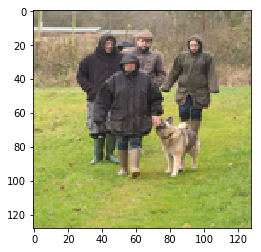

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
ROWS = 128
COLS = 128
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [6]:
train_dogs = prep_data(train_dogs)
train_cats = prep_data(train_cats)
validation_dogs = prep_data(validation_dogs)
validation_cats = prep_data(validation_cats)
test = prep_data(test_images)

Processed 0 of 7871
Processed 1000 of 7871
Processed 2000 of 7871
Processed 3000 of 7871
Processed 4000 of 7871
Processed 5000 of 7871
Processed 6000 of 7871
Processed 7000 of 7871
Processed 0 of 7853
Processed 1000 of 7853
Processed 2000 of 7853
Processed 3000 of 7853
Processed 4000 of 7853
Processed 5000 of 7853
Processed 6000 of 7853
Processed 7000 of 7853
Processed 0 of 976
Processed 0 of 988
Processed 0 of 200


In [7]:
print("Train DOG shape: {}".format(train_dogs.shape))
print("Train CAT shape: {}".format(train_cats.shape))
print("Validation DOG shape: {}".format(validation_dogs.shape))
print("Validation CAT shape: {}".format(validation_cats.shape))
print("Test shape: {}".format(test.shape))

Train DOG shape: (7871, 3, 128, 128)
Train CAT shape: (7853, 3, 128, 128)
Validation DOG shape: (976, 3, 128, 128)
Validation CAT shape: (988, 3, 128, 128)
Test shape: (200, 3, 128, 128)


# Labeling

In [8]:
train_X = np.concatenate((train_dogs, train_cats), axis=0)
train_y = np.concatenate((np.full(len(train_dogs), 1), np.full(len(train_cats), 0)), axis=0)
validation_X = np.concatenate((validation_dogs, validation_cats), axis=0)
validation_y = np.concatenate((np.full(len(validation_dogs), 1), np.full(len(validation_cats), 0)), axis=0)
test_X = test

print("train_X shape: {}".format(train_X.shape))
print("train_y shape: {}".format(train_y.shape))
print("validation_X shape: {}".format(validation_X.shape))
print("validation_y shape: {}".format(validation_y.shape))
print("test_X shape: {}".format(test.shape))

train_X shape: (15724, 3, 128, 128)
train_y shape: (15724,)
validation_X shape: (1964, 3, 128, 128)
validation_y shape: (1964,)
test_X shape: (200, 3, 128, 128)


# CNN Model

In [23]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu', name='conv1_1'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu', name='conv1_2'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th", name='pooling1'))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='conv2_1'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='conv2_2'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th", name='pooling2'))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', name='conv3_1'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', name='conv3_2'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th", name='pooling3'))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', name='conv4_1'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu', name='conv4_2'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th", name='pooling4'))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(3, 128, 1..., name="conv1_1")`
/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", name="conv1_2")`
/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2), name="pooling1")`
/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu", name="conv2_1")`
/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Ke

In [24]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        

In [30]:
nb_epoch = 10
batch_size = 16

history = LossHistory()
model.fit(train_X, train_y, validation_data=(validation_X, validation_y), 
          batch_size=batch_size, epochs=nb_epoch, shuffle=True, callbacks=[history, early_stopping])predictions = model.predict(test)

Train on 15724 samples, validate on 1964 samples
Epoch 1/10
 2976/15724 [====>.........................] - ETA: 282s - loss: 0.7129 - acc: 0.4845

KeyboardInterrupt: 

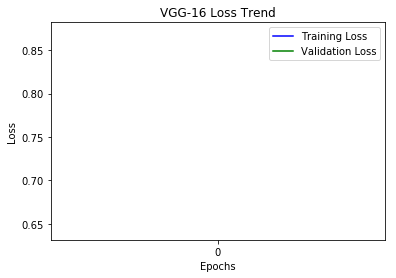

In [13]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(test)

In [32]:
predictions

NameError: name 'predictions' is not defined

In [39]:
Category = np.round(predictions)

NameError: name 'predictions' is not defined

In [ ]:
Category

In [40]:
test_id = [x[10:] for x in test_images]

In [41]:
result = pd.DataFrame(columns=['id','Category'], data=[test_id, Category])

NameError: name 'Category' is not defined

In [ ]:
result.to_csv('submission/baseline.csv', index=False)